# Deep $Q$-learning

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use $Q$-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://github.com/openai/gym). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import gym
import numpy as np

# Create the Cart-Pole game environment
env = gym.make('CartPole-v1')

# Number of possible actions
print('Number of possible actions:', env.action_space.n)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Number of possible actions: 2


We interact with the simulation through `env`.  You can see how many actions are possible from `env.action_space.n`, and to get a random action you can use `env.action_space.sample()`.  Passing in an action as an integer to `env.step` will generate the next step in the simulation.  This is general to all Gym games. 

In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.(**Discrete Actions**)

Run the code below to interact with the environment.

## Generating samples
We are generating sample action and relavent states for the observation. Or understing of environment.
* Action Space:
* State Space: the state has four values as a list
    1. The position of the cart
    2. The velocity of the cart
    3. The position of the pole 
    4. The velocity of the pole

In [2]:
actions = [] # actions that the agent selects
rewards = [] # obtained rewards
state = env.reset()

while True:
    action = env.action_space.sample()  # choose a random action
    state, reward, done, _ = env.step(action) 
    print('Action:{}, Next State: {}, Reward:{}'.format(action, state, reward))
    rewards.append(reward)
    actions.append(action)
    if done:
        break

Action:0, Next State: [ 0.01756515 -0.2057057  -0.00087005  0.25243692], Reward:1.0
Action:1, Next State: [ 0.01345104 -0.01057133  0.00417869 -0.04052031], Reward:1.0
Action:1, Next State: [ 0.01323961  0.18449045  0.00336828 -0.3318819 ], Reward:1.0
Action:0, Next State: [ 0.01692942 -0.01067929 -0.00326936 -0.03813869], Reward:1.0
Action:1, Next State: [ 0.01671583  0.1844894  -0.00403213 -0.33185133], Reward:1.0
Action:1, Next State: [ 0.02040562  0.37966851 -0.01066916 -0.62580306], Reward:1.0
Action:1, Next State: [ 0.02799899  0.57493776 -0.02318522 -0.92182694], Reward:1.0
Action:1, Next State: [ 0.03949775  0.77036519 -0.04162176 -1.22170515], Reward:1.0
Action:1, Next State: [ 0.05490505  0.965998   -0.06605586 -1.52713347], Reward:1.0
Action:1, Next State: [ 0.07422501  1.16185191 -0.09659853 -1.83967994], Reward:1.0
Action:1, Next State: [ 0.09746205  1.35789872 -0.13339213 -2.16073502], Reward:1.0
Action:0, Next State: [ 0.12462002  1.16431196 -0.17660683 -1.91203557], Rew

We can look at the actions and rewards:

In [3]:
print('Actions:', actions)
print('Rewards:', rewards)

Actions: [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0]
Rewards: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


The game resets after the pole has fallen past a certain angle. For each step while the game is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## $Q$-Network

To keep track of the action values, we'll use a neural network that accepts a **state $s$ as input**.  The **output will be $Q$-values** for each available action $a$ (i.e., the output is **all** action values $Q(s,a)$ _corresponding to the input state $s$_).

<img src="assets/q-network.png" width=550px>

For this Cart-Pole game, the state has four values: the position and velocity of the cart, and the position and velocity of the pole.  Thus, the neural network has **four inputs**, one for each value in the state, and **two outputs**, one for each possible action. 

As explored in the lesson, to get the training target, we'll first use the context provided by the state $s$ to choose an action $a$, then simulate the game using that action. This will get us the next state, $s'$, and the reward $r$. With that, we can calculate $\hat{Q}(s,a) = r + \gamma \max_{a'}{Q(s', a')}$.  Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

Below is one implementation of the $Q$-network. It uses two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [4]:
import tensorflow as tf

class QNetwork:
    def __init__(self, learning_rate=0.01, state_size=4, 
                 action_size=2, hidden_size=10, 
                 name='QNetwork'):
        # state inputs to the Q-network
        with tf.variable_scope(name):
            self.inputs_ = tf.placeholder(tf.float32, [None, state_size], name='inputs')
            
            # One hot encode the actions to later choose the Q-value for the action
            self.actions_ = tf.placeholder(tf.int32, [None], name='actions')
            one_hot_actions = tf.one_hot(self.actions_, action_size)
            
            # Target Q values for training
            self.targetQs_ = tf.placeholder(tf.float32, [None], name='target')
            
            # ReLU hidden layers
            self.fc1 = tf.contrib.layers.fully_connected(self.inputs_, hidden_size)
            self.fc2 = tf.contrib.layers.fully_connected(self.fc1, hidden_size)

            # Linear output layer
            self.output = tf.contrib.layers.fully_connected(self.fc2, action_size, 
                                                            activation_fn=None)
            
            ### Train with loss (targetQ - Q)^2
            # output has length 2, for two actions. This next line chooses
            # one value from output (per row) according to the one-hot encoded actions.
            self.Q = tf.reduce_sum(tf.multiply(self.output, one_hot_actions), axis=1)
            
            self.loss = tf.reduce_mean(tf.square(self.targetQs_ - self.Q))
            self.opt = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maximum capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [5]:
from collections import deque

class Memory():
    def __init__(self, max_size=1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## $Q$-Learning training algorithm

We will use the below algorithm to train the network.  For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode $\leftarrow 1$ **to** $M$ **do**
  * Observe $s_0$
  * **For** $t \leftarrow 0$ **to** $T-1$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s_t,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

You are welcome (and encouraged!) to take the time to extend this code to implement some of the improvements that we discussed in the lesson, to include fixed $Q$ targets, double DQNs, prioritized replay, and/or dueling networks.

## Hyperparameters

One of the more difficult aspects of reinforcement learning is the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [6]:
train_episodes = 5000          # max number of episodes to learn from
max_steps = 200                # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 0.0001         # Q-network learning rate

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 20                # experience mini-batch size
pretrain_length = batch_size   # number experiences to pretrain the memory

In [7]:
tf.reset_default_graph()
mainQN = QNetwork(name='main', hidden_size=hidden_size, learning_rate=learning_rate)

Instructions for updating:
Use the retry module or similar alternatives.


## Populate the experience memory

Here we re-initialize the simulation and pre-populate the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [8]:
# Initialize the simulation
env.reset()
# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for ii in range(pretrain_length):

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

## Training

Below we'll train our agent.

<IPython.core.display.Javascript object>


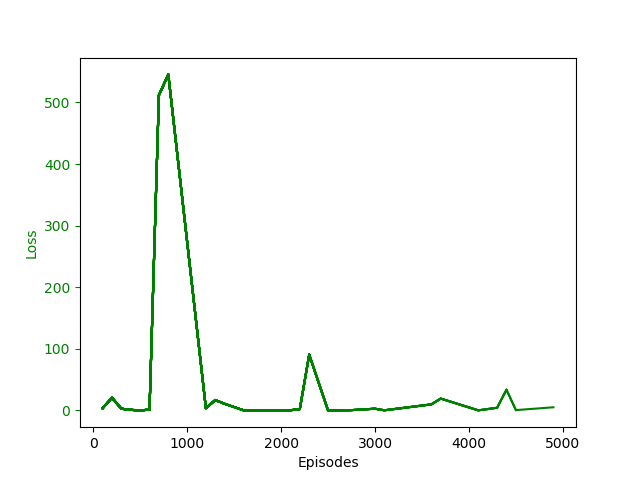

In [10]:
import matplotlib.pyplot as plt
%matplotlib notebook

# Create a plot
fig, sub1= plt.subplots(1,1)

# UI Configurations
sub1.set_xlabel('Episodes', color='k') 
sub1.set_ylabel('Loss', color='g')
sub1.tick_params(axis='x', colors='k')
sub1.tick_params(axis='y', colors="g")

def single_plot(x, y, color_y1='g', color_y2='b'):
   sub1.plot(x, y, color_y1)
   fig.canvas.draw()

In [11]:
# Now train with experiences
saver = tf.train.Saver()
rewards_list = []
episode_list = []
loss_list = []
with tf.Session() as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    step = 0
    for ep in range(1, train_episodes):
        total_reward = 0
        t = 0
        while t < max_steps:
            step += 1
            # Uncomment this next line to watch the training
            env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from Q-network
                feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
                Qs = sess.run(mainQN.output, feed_dict=feed)
                action = np.argmax(Qs)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
    
            total_reward += reward
            
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                if ep%100 == 0:
                    print('Episode: {}'.format(ep),
                          'Total reward: {}'.format(total_reward),
                          'Training loss: {:.4f}'.format(loss),
                          'Explore P: {:.4f}'.format(explore_p))
                    episode_list.append(ep)
                    loss_list.append(loss)
                    single_plot(episode_list, loss_list)
                rewards_list.append((ep, total_reward))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                env.reset()
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Train network
            target_Qs = sess.run(mainQN.output, feed_dict={mainQN.inputs_: next_states})
            
            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            target_Qs[episode_ends] = (0, 0)
            
            targets = rewards + gamma * np.max(target_Qs, axis=1)

            loss, _ = sess.run([mainQN.loss, mainQN.opt],
                                feed_dict={mainQN.inputs_: states,
                                           mainQN.targetQs_: targets,
                                           mainQN.actions_: actions})
        
    saver.save(sess, "checkpoints/cartpole.ckpt")

Episode: 100 Total reward: 18.0 Training loss: 3.4141 Explore P: 0.8200
Episode: 200 Total reward: 12.0 Training loss: 20.6733 Explore P: 0.6801
Episode: 300 Total reward: 31.0 Training loss: 2.8163 Explore P: 0.4554
Episode: 400 Total reward: 99.0 Training loss: 0.9474 Explore P: 0.1718
Episode: 500 Total reward: 165.0 Training loss: 0.0891 Explore P: 0.0469
Episode: 600 Total reward: 12.0 Training loss: 1.2786 Explore P: 0.0220
Episode: 700 Total reward: 10.0 Training loss: 511.7465 Explore P: 0.0204
Episode: 800 Total reward: 123.0 Training loss: 545.5873 Explore P: 0.0136
Episode: 1200 Total reward: 11.0 Training loss: 3.6368 Explore P: 0.0100
Episode: 1300 Total reward: 17.0 Training loss: 16.8518 Explore P: 0.0100
Episode: 1400 Total reward: 24.0 Training loss: 10.7451 Explore P: 0.0100
Episode: 1600 Total reward: 99.0 Training loss: 0.3054 Explore P: 0.0100
Episode: 2100 Total reward: 9.0 Training loss: 0.3449 Explore P: 0.0100
Episode: 2200 Total reward: 99.0 Training loss: 2.1

## Visualizing training

Below we plot the total rewards for each episode. The rolling average is plotted in blue.

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total Reward')

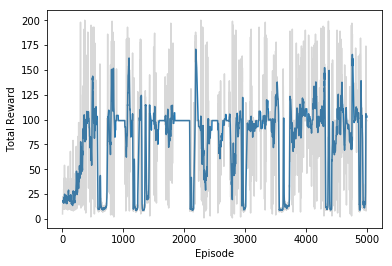

In [13]:
eps, rews = np.array(rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')


## Playing Atari Games

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.